In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGeneratorMod
from segment_anything import SamAutomaticMaskGenerator as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import functions as fnc
import First_second_fnc as FS_fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import time
from skimage.morphology import binary_dilation
import json
from tqdm import tqdm
import pandas as pd


In [2]:
#load image
OutDIR='/DATA/vito/output/Ravi3_run2_dw4_cp512_3b_minarea/'

with open(OutDIR+'init_para.json', 'r') as json_file:
    init_para = json.load(json_file)
with open(OutDIR+'pre_para.json', 'r') as json_file:
    pre_para = json.load(json_file)

DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=init_para.get('fid')
resample_factor=init_para.get('resample_factor')

image=fnc.load_image(DataDIR,DSname,fid)
print('Image size:', image.shape)

Ravi3_orthomosaic_clip_02mm.tif imported
Image size: (28382, 32563, 3)


In [3]:
id_mask=np.load(OutDIR+'Third/all_mask_third_pass_id.npy')
id_mask=fnc.resample_fnc(id_mask.astype(np.uint16),{'target_size': image.shape[:-1][::-1],'method': 'nearest'})

x,y=np.mean(np.where((id_mask==2012)>0),axis=1)
x,y=int(x),int(y)

crop_size=1024
resample_factor=1/4
temp_id_mask=fnc.resample_fnc(id_mask.astype(np.uint16),{'fxy': resample_factor,'method': 'nearest'})
label_area=np.sum(temp_id_mask==2012)
y,x=np.mean(np.where((temp_id_mask==2012)),axis=1)
x0,y0=int(x),int(y)
xmin,ymin=x0-crop_size/2,y0-crop_size/2
ji=xmin/crop_size
ii=ymin/crop_size
if ji<0:
    ji=0
if ii<0:
    ii=0

#prepare image
dw_image=fnc.resample_fnc(image,{'fxy': resample_factor})
pre_para={'Resample':{'fxy': resample_factor},'Crop': {'crop size': crop_size, 'j':ji,'i':ii}}
temp_image=fnc.preprocessing_roulette(image, pre_para)

In [5]:
gc.collect()
torch.cuda.empty_cache()
#setup SAM
MODEL_TYPE = "vit_h"
DEVICE, CHECKPOINT_PATH=fnc.set_sam(MODEL_TYPE, DataDIR)
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)


Currently running on GPU
Model vit_h


/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Not resampling
Not resampling
Not resampling


/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


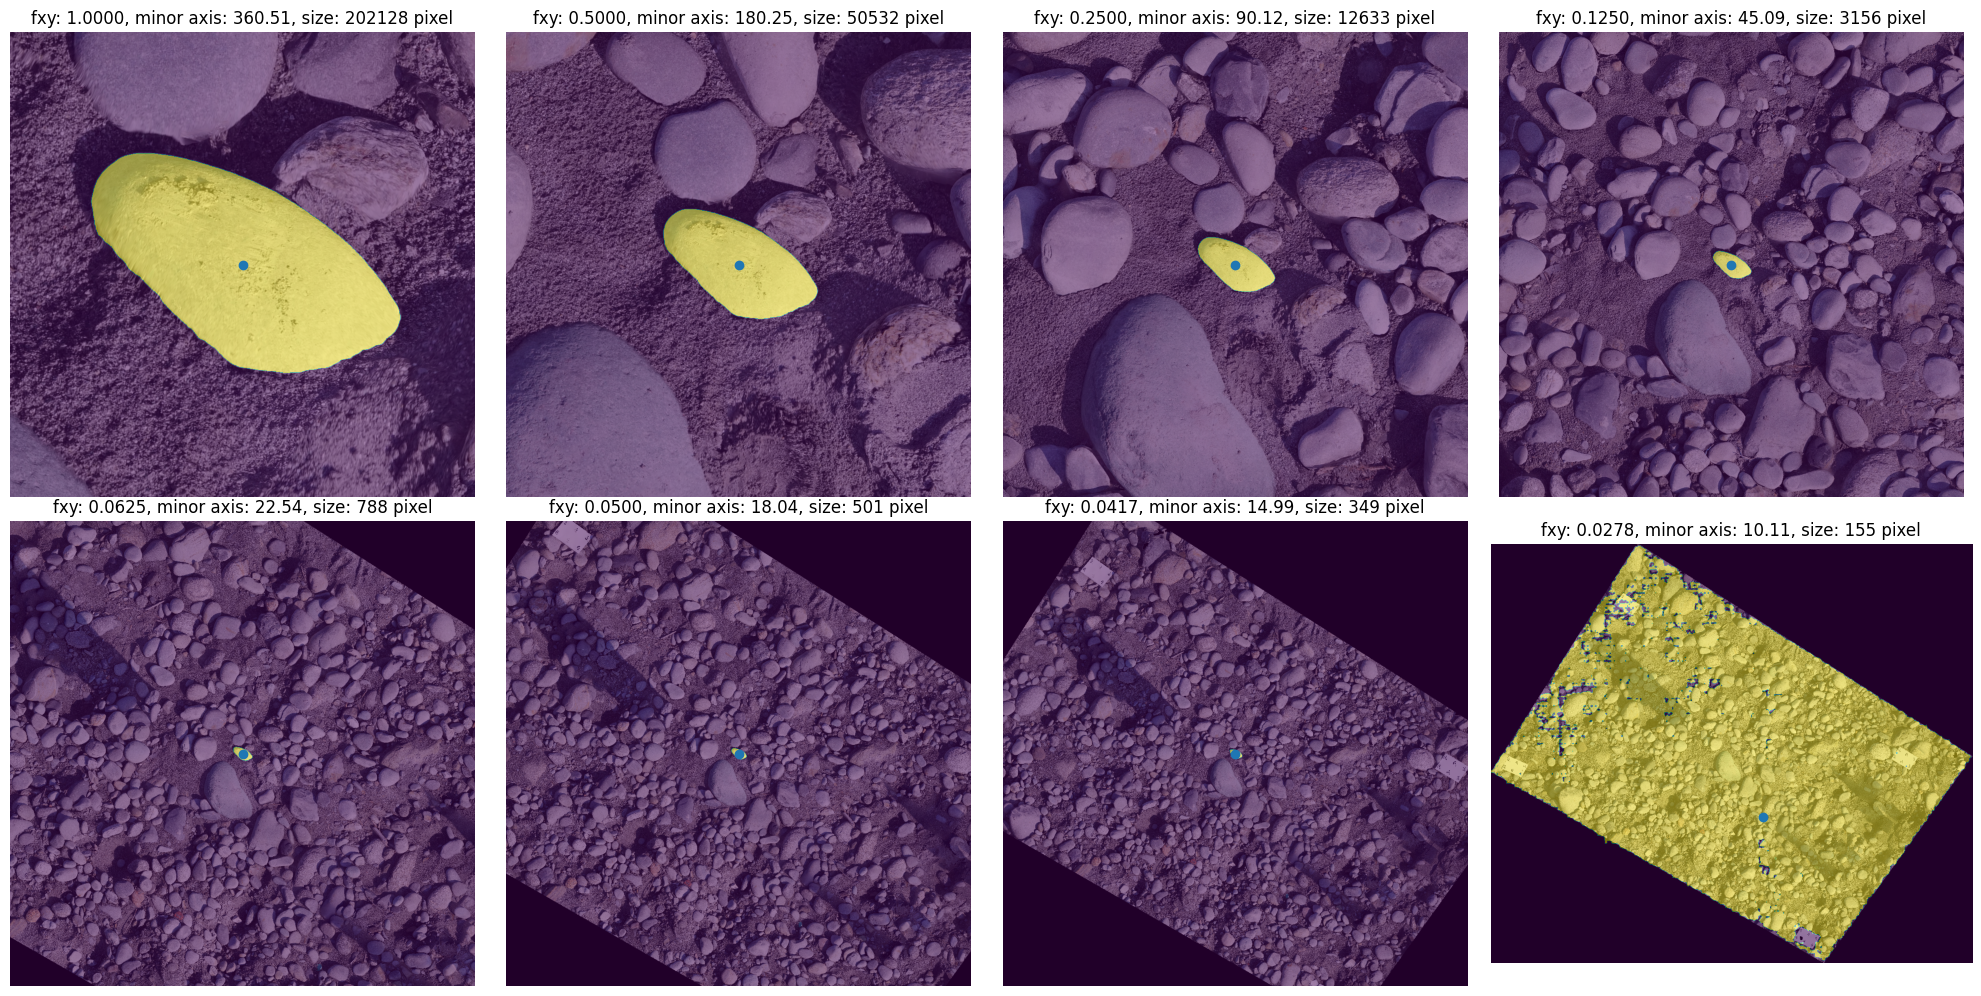

In [9]:
factor_list=[1,1/2,1/4,1/8,1/16,1/20,1/24,1/36]
all_mask=[]
area_list=[]
minor_axis_list=[]
crop_size=1024
plt.figure(figsize=(20,10))
for ind, resample_factor in enumerate(factor_list):

    temp_id_mask=fnc.resample_fnc(id_mask.astype(np.uint16),{'fxy': resample_factor,'method': 'nearest'})
    label_area=np.sum(temp_id_mask==2012)
    y,x=np.mean(np.where((temp_id_mask==2012)),axis=1)
    x0,y0=int(x),int(y)
    xmin,ymin=x0-crop_size/2,y0-crop_size/2
    ji=xmin/crop_size
    ii=ymin/crop_size
    if ji<0:
        ji=0
    if ii<0:
        ii=0

    #prepare image
    dw_image=fnc.resample_fnc(image,{'fxy': resample_factor})
    pre_para={'Resample':{'fxy': resample_factor},'Crop': {'crop size': crop_size, 'j':ji,'i':ii}}
    temp_image=fnc.preprocessing_roulette(image, pre_para)

    #clear gpu ram and setup sam
    gc.collect()
    torch.cuda.empty_cache()
    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
    sam.to(device=DEVICE)
    predictor = SamPredictor(sam)
    predictor.set_image(temp_image)

    input_point = np.array([[int(x0-xmin),int(y0-ymin)]])
    input_label = np.array([1])

    gc.collect()
    torch.cuda.empty_cache()

    partmasks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,)
    best_idx=np.argmax(scores)#pick the mask with highest score
    mask=partmasks[best_idx].astype('bool')
    mask=fnc.clean_mask(mask)
            
    #for mask in void_pointed_reseg:
    #if not (np.any(mask[0]==1) or np.any(mask[-1]==1) or np.any(mask[:,0]==1) or np.any(mask[:,-1]==1)):
    resize=np.zeros(dw_image.shape[:-1])
    Valid_area=resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)].shape
    if Valid_area==(crop_size,crop_size):
        resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask
    else:
        resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask[:Valid_area[0],:Valid_area[1]]
    resize=fnc.resample_fnc(resize,{'target_size':image.shape[:-1][::-1],'method': 'nearest'}).astype('bool')
    all_mask.append(resize)
    
    labels = label(temp_id_mask==2012)
    regions = regionprops(labels)
    regions = sorted(regions, key=lambda x: x.area, reverse=True)
    area_list.append(label_area)
    minor_axis_list.append(regions[0].axis_minor_length)
    plt.subplot(2,4,ind+1)
    plt.imshow(temp_image)
    plt.imshow(mask,alpha=0.5)
    plt.scatter(int(y0-ymin),int(x0-xmin))
    plt.title(f'fxy: {resample_factor:.4f}, minor axis: {regions[0].axis_minor_length:.2f}, size: {int(regions[0].area)} pixel')
    plt.axis('off')

plt.tight_layout()
iou_list=[]
truth=id_mask==2012
for i in range(len(all_mask)):
    iou_list.append(fnc.iou(truth,all_mask[i]))

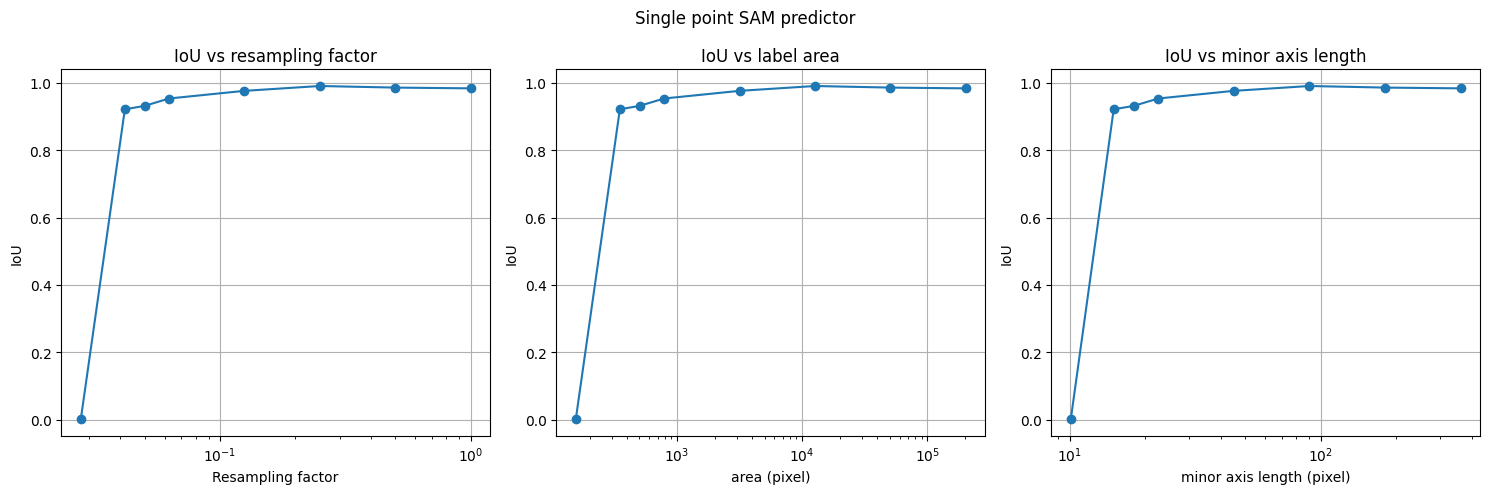

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(factor_list,iou_list,'-o')
plt.xscale('log')
plt.grid()
plt.xlabel('Resampling factor')
plt.ylabel('IoU')
plt.title('IoU vs resampling factor')

plt.subplot(1,3,2)
plt.plot(area_list,iou_list,'-o')
plt.grid()
plt.xscale('log')
plt.xlabel('area (pixel)')
plt.ylabel('IoU')
plt.title('IoU vs label area')

plt.subplot(1,3,3)
plt.plot(minor_axis_list,iou_list,'-o')
plt.xscale('log')
plt.grid()
plt.xlabel('minor axis length (pixel)')
plt.ylabel('IoU')
plt.title('IoU vs minor axis length')

plt.suptitle('Single point SAM predictor')
plt.tight_layout()

plt.show()

In [5]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)
pps=init_para.get('point_per_side')
#window_step=init_para.get('window_step')
b=init_para.get('b')
stb_t=init_para.get('stability_t')
#defining clips
crop_size=init_para.get('crop_size')
resample_factor=init_para.get('resample_factor')
min_pixel=(init_para.get('expected_min_size(sqmm)')/(init_para.get('resolution(mm)')**2))*resample_factor
min_radi=init_para.get('min_radius')

def filter_by_pred_iou_and_size_per_seedpoint(masks,size_threshold=0.4,crop_size=crop_size):
    seed_point=np.array([mask['point_coords'][0] for mask in masks])
    highest_pred_iou_by_point=[]
    i=0
    while i < len(masks):
        i0=i
        if (i+2)<len(masks):
            if np.all(seed_point[i]==seed_point[i+2]):
                i+=2
            elif np.all(seed_point[i]==seed_point[i+1]):
                i+=1
        elif (i+1)<len(masks):
            if np.all(seed_point[i]==seed_point[i+1]):
                i+=1
        iou=[mask['predicted_iou'] for mask in masks[i0:i+1]]
        idx=np.argsort(iou)[::-1]
        pick=0

        while pick < len(idx):
            mask_area = np.sum(masks[idx[pick] + i0]['segmentation'])
            # if mask is very large compared to size of the image (credit:segment everygrain) modified from 0.1 to 0.4
            if mask_area / (crop_size ** 2) <= size_threshold:
                break
            else:
                pick += 1
        if pick<len(idx):
            highest_pred_iou_by_point.append(masks[idx[pick]+i0])
        i+=1
    return highest_pred_iou_by_point

def Groupping_masks(list_of_masks):

    ar_masks=np.stack(list_of_masks)
    ar_masks_flat=ar_masks.reshape((ar_masks.shape[0],ar_masks.shape[1]*ar_masks.shape[2]))#flat 2d to 1d masks

    #find pixel-wise overlaps
    list_overlap=[]
    # Iterate through each column of the array
    for i in range(ar_masks_flat.shape[1]):
        # for each pixel find out the idex of mask where the pixel was in a mask
        nz = np.where(ar_masks_flat[:, i] != 0)[0]
        
        # if there are overlap of mask
        if len(nz) > 1:
            list_overlap.append(tuple(nz))

    #get uniqe pairs and intersection area(pixel) for each pair
    group_counter=Counter(list_overlap)
    unique_groups = [list(tup) for tup in group_counter.keys()]
    group_overlap_area = list(group_counter.values())
    return group_overlap_area, unique_groups, list_overlap

def filter_groupping_by_intersection(group_overlap_area,unique_groups, list_overlap ,intersection_threshold=1000):
    #filter by intersection area
    filtered=np.array(group_overlap_area)>intersection_threshold
    unique_groups_thresholded=[unique_groups[i] for i in range(len(unique_groups)) if filtered[i]]
    #report filter
    print(f'Threshold: {intersection_threshold} pixels, {len(list_overlap)-len(unique_groups_thresholded)} groups removed',
        f'\nOverlap groups before filtering: {len(list_overlap)}, after filtering: {len(unique_groups_thresholded)}')
    return unique_groups_thresholded

def checking_remaining_ungroupped(list_of_masks, unique_groups_thresholded):
    #check if there is remaining ungroupped pairs
    checker=np.zeros(len(list_of_masks))
    for gp in unique_groups_thresholded:
        for i in gp:
            checker[i]+=1
    remaining_ungroupped=np.max(np.unique(checker))

    cleaned_groups=None#dummy to identify first run

    while remaining_ungroupped>1:#keep groupping until there is no overlapping groups
        groups=[]
        if not cleaned_groups:#the first run
            temp_list_overlap=unique_groups_thresholded.copy()
        else:#>2 run
            temp_list_overlap=cleaned_groups.copy()

        while len(temp_list_overlap)>1:
            temp_group=temp_list_overlap[0].copy()
            remaining=[]
            for i in np.arange(1,len(temp_list_overlap),1):
                num_common_val=len(np.intersect1d(temp_list_overlap[0],temp_list_overlap[i]))
                if num_common_val!=0:
                    temp_group=np.hstack((temp_group,temp_list_overlap[i]))
                else:
                    remaining.append(temp_list_overlap[i])
            temp_list_overlap=remaining.copy()
            groups.append(temp_group)
        if len(remaining)>0:
            groups.append(remaining[0])

        #remove duplicated index after stacking
        cleaned_groups=[np.unique(group) for group in groups]

        checker=np.zeros(len(masks))
        for gp in cleaned_groups:
            for i in gp:
                checker[i]+=1
        remaining_ungroupped=np.max(np.unique(checker))
    if cleaned_groups:
        all_grouped_masks=np.unique(np.hstack(cleaned_groups))
        if len(all_grouped_masks)!=len(list_of_masks):
            list_of_nooverlap_mask=np.setdiff1d(np.arange(len(list_of_masks)), all_grouped_masks)
        else:
            list_of_nooverlap_mask=[]
    elif len(unique_groups_thresholded)>0:
        cleaned_groups=unique_groups_thresholded
        all_grouped_masks=np.unique(np.hstack(cleaned_groups))
        list_of_nooverlap_mask=np.setdiff1d(np.arange(len(list_of_masks)), all_grouped_masks)
        #list_of_nooverlap_mask=np.unique(np.hstack(unique_groups_thresholded))
    else:
        cleaned_groups=None
        list_of_nooverlap_mask=np.arange(len(list_of_masks))
    return cleaned_groups, list_of_nooverlap_mask

def Guided_second_pass_SAM(cleaned_groups, min_pixel, min_radi,tm=0.5):
    ##problem--we are assuming that in each disconnected region there is only one object
    cleaned_groups_reseg=[]
    for k in range(len(cleaned_groups)):
        stacked=np.stack([list_of_masks[i] for i in cleaned_groups[k]])
        mean_stacked=np.mean(stacked,axis=0)
        #std_stacked=np.std(stacked,axis=0)

        #separate high confidence region(high mean) and low
        labels=label(np.logical_and(mean_stacked<=tm,mean_stacked>0))
        regions=regionprops(labels)
        labels=label(np.logical_and(mean_stacked>tm,mean_stacked>0))
        regions_highmean=regionprops(labels)
        for region in regions_highmean:
            regions.append(region) 

        for props in regions:
            if (props.area>100):#apply minimum area to filter out mini residuals
                y0, x0 = props.centroid
                input_point = np.array([[x0,y0]])
                input_label = np.array([1])

                partmasks, scores, logits = predictor.predict(
                    point_coords=input_point,
                    point_labels=input_label,
                    multimask_output=True,)
                best_idx=np.argmax(scores)#pick the mask with highest score
                if fnc.area_radi(partmasks[best_idx], min_pixel, min_radi):
                    cleaned_groups_reseg.append({'mask':partmasks[best_idx],'score':scores[best_idx],'logit':logits[best_idx],'group':k})
    
    list_of_cleaned_groups_reseg_masks = [fnc.clean_mask(mask['mask'].astype('bool')) for mask in cleaned_groups_reseg]
    list_of_cleaned_groups_reseg_score=[mask['score'] for mask in cleaned_groups_reseg]
    return list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score

/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Not resampling
Not resampling
Not resampling
First pass SAM:  1630  mask(s) found
Filtered by highest predicted iou per seed point,  284  mask(s) remains
Threshold: 1000 pixels, 241757 groups removed 
Overlap groups before filtering: 241772, after filtering: 15
Found  18  mask(s)/object(s) in the clip
First pass SAM:  1718  mask(s) found
Filtered by highest predicted iou per seed point,  440  mask(s) remains
Threshold: 1000 pixels, 432478 groups removed 
Overlap groups before filtering: 432507, after filtering: 29
Found  24  mask(s)/object(s) in the clip
First pass SAM:  1474  mask(s) found
Filtered by highest predicted iou per seed point,  607  mask(s) remains
Threshold: 1000 pixels, 495711 groups removed 
Overlap groups before filtering: 495773, after filtering: 62
Found  85  mask(s)/object(s) in the clip
First pass SAM:  1779  mask(s) found
Filtered by highest predicted iou per seed point,  808  mask(s) remains
Threshold: 1000 pixels, 513482 groups removed 
Overlap groups before fil

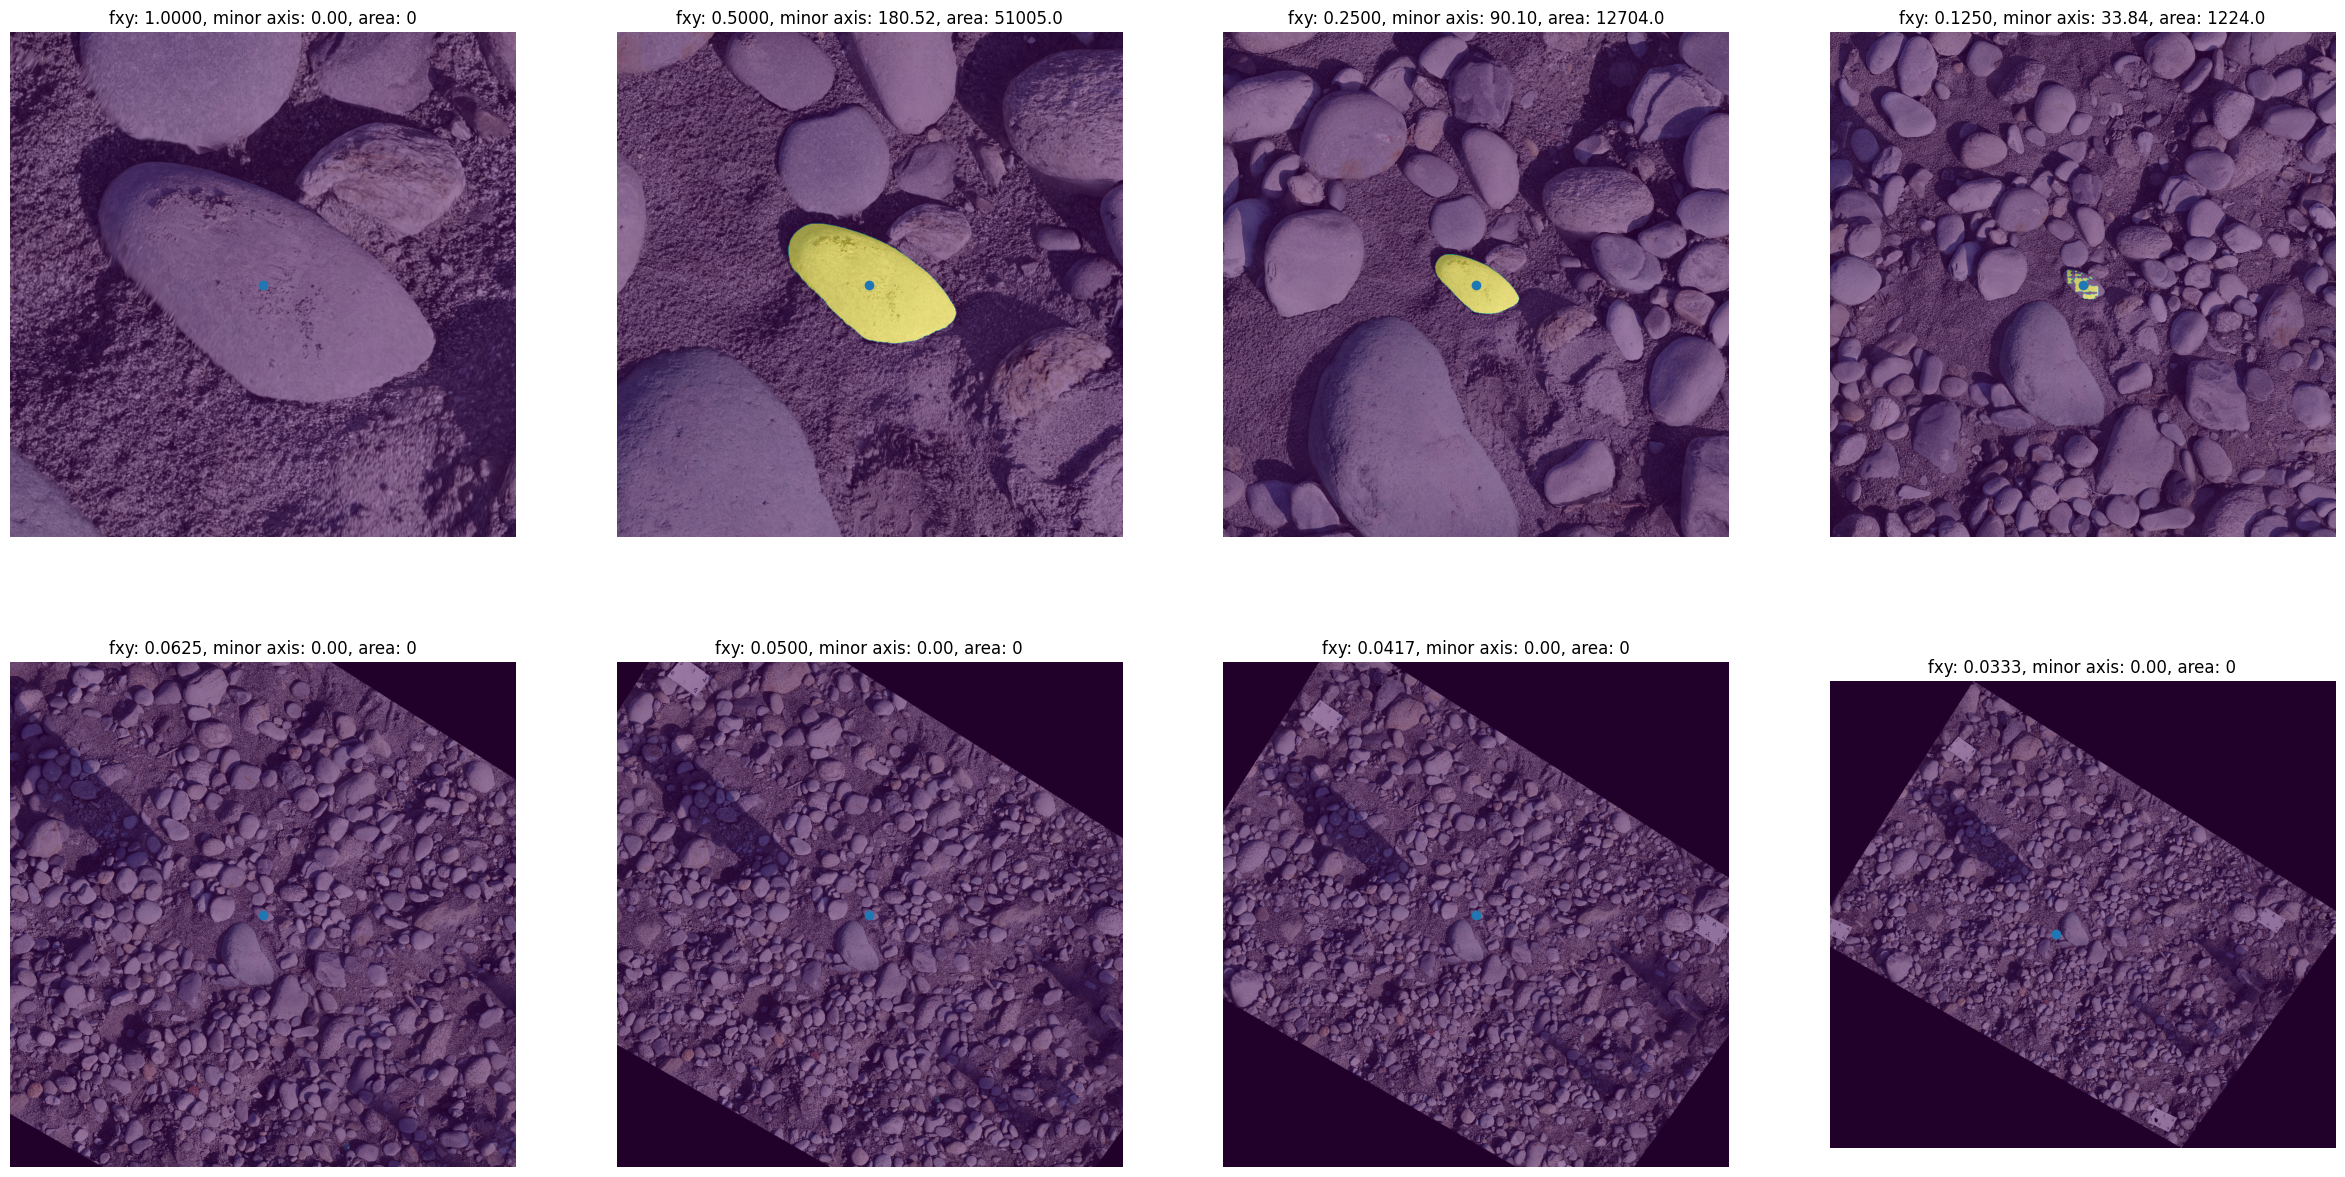

In [31]:
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGenerator
factor_list=[1,1/2,1/4,1/8,1/16,1/20,1/24,1/30]
all_mask=[]
all_ids=[]
area_list=[]
minor_axis_list=[]
crop_size=1024
plt.figure(figsize=(30,15))
for ind, resample_factor in enumerate(factor_list):

    temp_id_mask=fnc.resample_fnc(id_mask.astype(np.uint16),{'fxy': resample_factor,'method': 'nearest'})
    y,x=np.mean(np.where((temp_id_mask==2012)),axis=1)
    x0,y0=int(x),int(y)
    xmin,ymin=x0-crop_size/2,y0-crop_size/2
    ji=xmin/crop_size
    ii=ymin/crop_size
    if ji<0:
        ji=0
    if ii<0:
        ii=0

    #prepare image
    dw_image=fnc.resample_fnc(image,{'fxy': resample_factor})
    pre_para={'Resample':{'fxy': resample_factor}}
    temp_image=fnc.preprocessing_roulette(image, pre_para)
    patches = fnc.get_image_patches(image, crop_size, 2*b)
    patch_keys=patches.keys()
    max_ij=np.max(np.array(list(patch_keys)),axis=0)
    pre_para={'Crop': {'crop size': crop_size, 'j':ji,'i':ii}}
    temp_image=fnc.preprocessing_roulette(temp_image, pre_para)
    temp_id_mask=fnc.preprocessing_roulette(temp_id_mask, pre_para)
    y,x=np.mean(np.where((temp_id_mask==2012)),axis=1)
    x0,y0=int(x),int(y)



    #clear gpu ram and setup sam
    gc.collect()
    torch.cuda.empty_cache()

    #SAM segmentation
    mask_generator = SamAutomaticMaskGenerator(
        model=sam,
        points_per_side=pps,
        pred_iou_thresh=0,
        stability_score_thresh=stb_t,#iou by varying cutoff in binary conversion
        box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
        crop_n_layers=0,#cut into 2**n crops
        crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
        crop_n_points_downscale_factor=1,
        crop_overlap_ratio=0,
        #min_mask_region_area=2000,
    )
    predictor = SamPredictor(sam)
    predictor.set_image(temp_image)

    with torch.no_grad():
        masks = mask_generator.generate(temp_image)
    print('First pass SAM: ', len(masks),' mask(s) found')

    #post processing
    #filter output mask per point by select highest pred iou mask
    masks=filter_by_pred_iou_and_size_per_seedpoint(masks)
    print('Filtered by highest predicted iou per seed point, ', len(masks),' mask(s) remains')

    list_of_pred_iou = [mask['predicted_iou'] for mask in masks]
    list_of_masks = [fnc.clean_mask(mask['segmentation'].astype('bool')) for mask in masks]#remove small disconnected parts
    no_area_after_cleaning=np.array([np.sum(mask)==0 for mask in list_of_masks])
    area_radi=np.array([fnc.area_radi(mask, min_pixel, min_radi) for mask in list_of_masks])
    if np.any(no_area_after_cleaning):
        list_of_masks = [mask for mask, keep in zip(list_of_masks, ~no_area_after_cleaning) if keep]
        list_of_pred_iou = [iou for iou, keep in zip(list_of_pred_iou, ~no_area_after_cleaning) if keep]
    if not np.all(area_radi):
        list_of_masks = [mask for mask, keep in zip(list_of_masks, area_radi) if keep]
        list_of_pred_iou = [iou for iou, keep in zip(list_of_pred_iou, area_radi) if keep]
    #remove background/edge mask
    flattened_rgb=np.sum(temp_image,axis=2)
    not_background_mask=np.array([np.any(flattened_rgb[mask.astype('bool')]>0) for mask in list_of_masks])
    if not np.all(not_background_mask):
        list_of_masks = [mask for mask, keep in zip(list_of_masks, not_background_mask) if keep]
        list_of_pred_iou = [mask for mask, keep in zip(list_of_pred_iou, not_background_mask) if keep]
        print('Background masks removed')

    if len(list_of_masks)>0:
        #grouping overlaps
        list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms=[],[]
        group_overlap_area, unique_groups, list_overlap = Groupping_masks(list_of_masks)
        unique_groups_thresholded = filter_groupping_by_intersection(group_overlap_area,unique_groups, list_overlap)
        cleaned_groups, list_of_nooverlap_mask = checking_remaining_ungroupped(list_of_masks, unique_groups_thresholded)
        if cleaned_groups:
            list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score = Guided_second_pass_SAM(cleaned_groups, min_pixel, min_radi)
            if len(list_of_nooverlap_mask)>0:
                for m in list_of_nooverlap_mask:
                    list_of_cleaned_groups_reseg_masks.append(list_of_masks[m].astype('bool'))
                    list_of_cleaned_groups_reseg_score.append(list_of_pred_iou[m])
                list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms = fnc.nms(list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score)
                print('Found ',len(list_of_cleaned_groups_reseg_score_nms), ' mask(s)/object(s) in the clip')
        else:
            list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score = list_of_masks, list_of_pred_iou
            list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms = fnc.nms(list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score)
        
        #valid box
        if len(list_of_cleaned_groups_reseg_masks_nms)>0:
            keep = [fnc.mask_in_valid_box(mask,b, [y0,x0], max_ij) for mask in list_of_cleaned_groups_reseg_masks_nms]
            list_of_cleaned_groups_reseg_masks_nms=[list_of_cleaned_groups_reseg_masks_nms[i] for i,k in enumerate(keep) if k]
            list_of_cleaned_groups_reseg_score_nms=[list_of_cleaned_groups_reseg_score_nms[i] for i,k in enumerate(keep) if k]
            if len(list_of_cleaned_groups_reseg_masks_nms)>0:
                stacked_id=np.sum([mask*(i+1) for i, mask in enumerate(list_of_cleaned_groups_reseg_masks_nms)], axis=0)
    
    all_ids.append(stacked_id)
    mask=stacked_id==(stacked_id[int(x0),int(y0)])
    if (stacked_id[int(x0),int(y0)]!=0 and (not (np.any(mask[0]==1) or np.any(mask[-1]==1) or np.any(mask[:,0]==1) or np.any(mask[:,-1]==1)))):
        labels = label(mask)
        regions = regionprops(labels)
        regions = sorted(regions, key=lambda x: x.area, reverse=True)
        area=regions[0].area
        minor_axis=regions[0].axis_minor_length
        
    else:
        mask=stacked_id*0
        area=0
        minor_axis=0
    area_list.append(area)
    minor_axis_list.append(minor_axis)
    #for mask in void_pointed_reseg:
    #if not (np.any(mask[0]==1) or np.any(mask[-1]==1) or np.any(mask[:,0]==1) or np.any(mask[:,-1]==1)):
    resize=np.zeros(dw_image.shape[:-1])
    Valid_area=resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)].shape
    if Valid_area==(crop_size,crop_size):
        resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask
    else:
        resize[int(crop_size*ii):int(crop_size*ii+crop_size),int(crop_size*ji):int(crop_size*ji+crop_size)]=mask[:Valid_area[0],:Valid_area[1]]
    resize=fnc.resample_fnc(resize,{'target_size':image.shape[:-1][::-1],'method': 'nearest'}).astype('bool')
    all_mask.append(resize)
    
    
    plt.subplot(2,4,ind+1)
    plt.imshow(temp_image)
    plt.imshow(mask,alpha=0.5)
    plt.scatter(int(y0),int(x0))
    plt.title(f'fxy: {resample_factor:.4f}, minor axis: {minor_axis:.2f}, area: {area}')
    plt.axis('off')

In [33]:
iou_list=[]
for i in range(len(all_mask)):
    iou_list.append(fnc.iou(id_mask==2012,all_mask[i]))

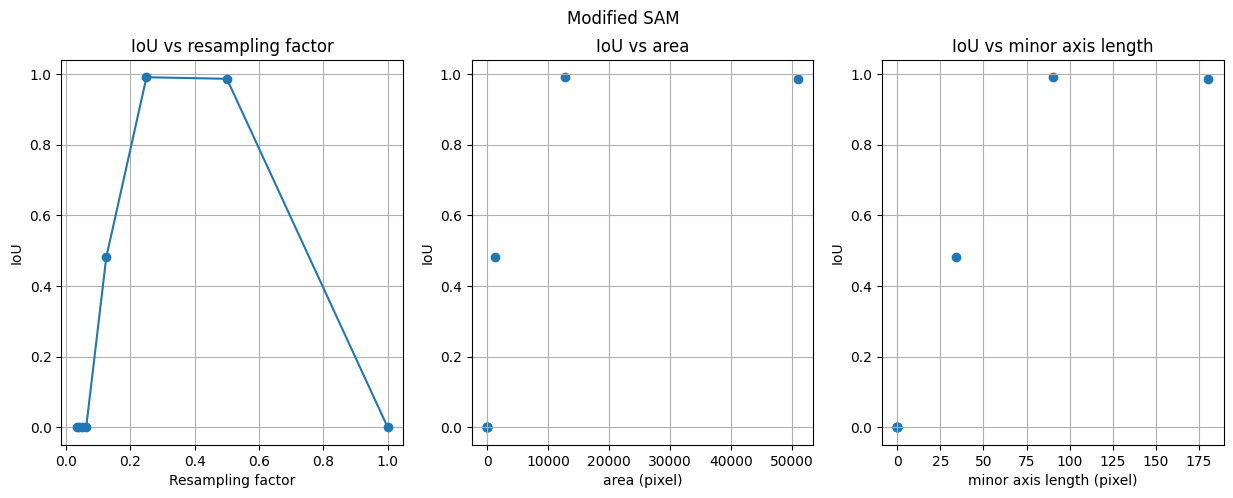

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(factor_list,iou_list,'-o')
plt.grid()
plt.xlabel('Resampling factor')
plt.ylabel('IoU')
plt.title('IoU vs resampling factor')

plt.subplot(1,3,2)
plt.scatter(area_list,iou_list)
plt.grid()
plt.xlabel('area (pixel)')
plt.ylabel('IoU')
plt.title('IoU vs area')

plt.subplot(1,3,3)
plt.scatter(minor_axis_list,iou_list)
plt.grid()
plt.xlabel('minor axis length (pixel)')
plt.ylabel('IoU')
plt.title('IoU vs minor axis length')

plt.suptitle('Modified SAM')

plt.show()